In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16, efficientnet_b0
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import warnings

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda
GPU memory: 4.0 GB


In [3]:
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle']

Step 1: Loading CIFAR-100 dataset and selecting first 10 classes
Files already downloaded and verified
Files already downloaded and verified
Selected classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
Number of training samples: 5000
Number of test samples: 1000


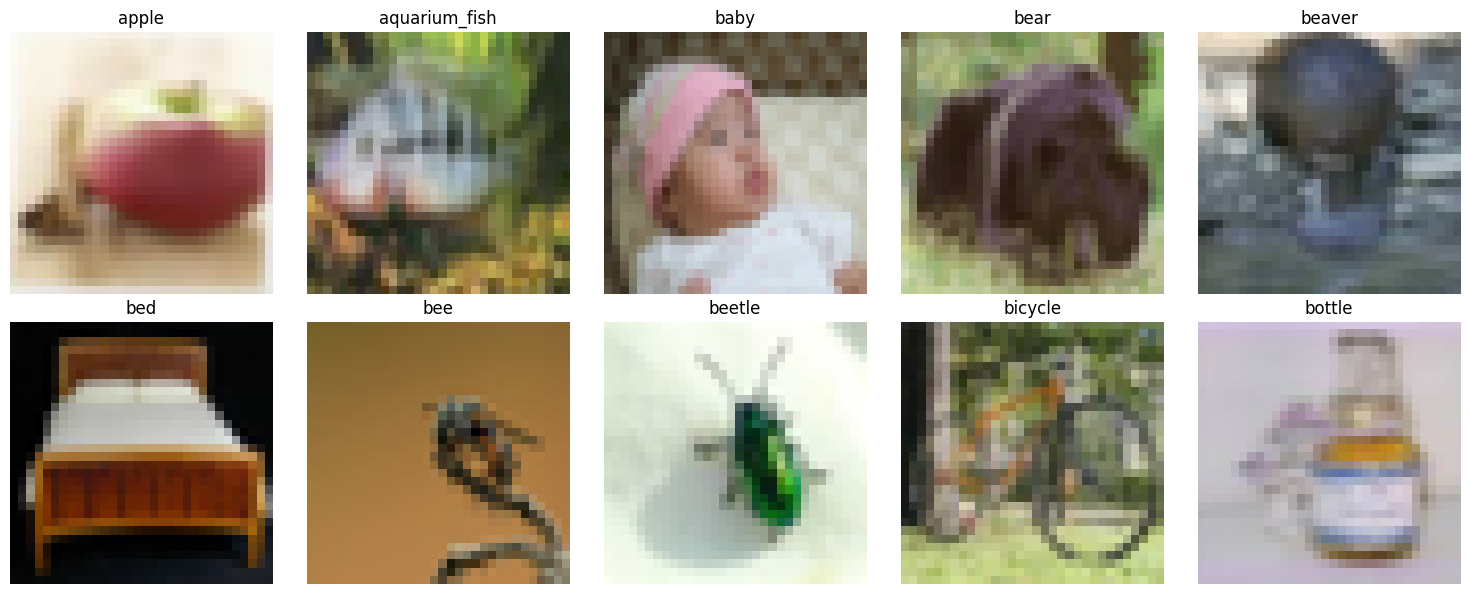

In [4]:
print("Step 1: Loading CIFAR-100 dataset and selecting first 10 classes")
print("="*60)

# Initial transform for loading data
initial_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

# Load CIFAR-100 dataset
full_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                              download=True, transform=initial_transform)
full_testset = torchvision.datasets.CIFAR100(root='./data', train=False, 
                                             download=True, transform=initial_transform)

# Filter first 10 classes
def filter_dataset(dataset, num_classes=10):
    indices = [i for i, (_, label) in enumerate(dataset) if label < num_classes]
    return Subset(dataset, indices)

train_subset = filter_dataset(full_trainset, 10)
test_subset = filter_dataset(full_testset, 10)

print(f"Selected classes: {cifar100_classes[:10]}")
print(f"Number of training samples: {len(train_subset)}")
print(f"Number of test samples: {len(test_subset)}")

# Visualize first 10 classes
def show_class_samples():
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    # Get one sample from each class
    class_samples = {}
    for i, (image, label) in enumerate(full_trainset):
        if label < 10 and label not in class_samples:
            class_samples[label] = image
        if len(class_samples) == 10:
            break
    
    for i in range(10):
        image = class_samples[i]
        # Denormalize for display
        image = image * torch.tensor([0.2673, 0.2564, 0.2762]).view(3, 1, 1) + torch.tensor([0.5071, 0.4865, 0.4409]).view(3, 1, 1)
        image = torch.clamp(image, 0, 1)
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(cifar100_classes[i])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_class_samples()

In [5]:
# Step 2: Preprocessing for different models
print("\nStep 2: Preprocessing datasets for different models")
print("="*60)

# Transform for VGG16 and EfficientNet (resize to 224x224)
transform_big_models = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet normalization
])

# Transform for small CNN (resize to 224x224)
transform_small_cnn = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])



Step 2: Preprocessing datasets for different models


In [6]:
# Create datasets with appropriate transforms
train_dataset_big = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                                   transform=transform_big_models)
test_dataset_big = torchvision.datasets.CIFAR100(root='./data', train=False, 
                                                  transform=transform_big_models)

train_dataset_small = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                                     transform=transform_small_cnn)
test_dataset_small = torchvision.datasets.CIFAR100(root='./data', train=False, 
                                                    transform=transform_small_cnn)

In [7]:
# Filter for 10 classes
train_subset_big = filter_dataset(train_dataset_big, 10)
test_subset_big = filter_dataset(test_dataset_big, 10)
train_subset_small = filter_dataset(train_dataset_small, 10)
test_subset_small = filter_dataset(test_dataset_small, 10)

# Data loaders
batch_size = 32  # Reduced for 4GB GPU
train_loader_big = DataLoader(train_subset_big, batch_size=batch_size, shuffle=True)
test_loader_big = DataLoader(test_subset_big, batch_size=batch_size, shuffle=False)
train_loader_small = DataLoader(train_subset_small, batch_size=batch_size, shuffle=True)
test_loader_small = DataLoader(test_subset_small, batch_size=batch_size, shuffle=False)

In [8]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [9]:
# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
# Initialize small CNN
small_cnn = SmallCNN(num_classes=10).to(device)

In [11]:
print(f"Small CNN trainable parameters: {count_parameters(small_cnn):,}")

Small CNN trainable parameters: 156,074


In [12]:
# Training function
def train_model(model, train_loader, test_loader, epochs, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        scheduler.step()
        
        # Testing phase
        model.eval()
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        train_acc = 100 * correct_train / total_train
        test_acc = 100 * correct_test / total_test
        
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
        
        # Stop if test accuracy reaches around 62%
        if test_acc >= 60 and test_acc <= 62:
            print(f"Stopping early at epoch {epoch+1} with test accuracy: {test_acc:.2f}%")
            break
    
    return train_losses, train_accuracies, test_accuracies

In [13]:
# Train small CNN
print("Training Small CNN...")
small_cnn_losses, small_cnn_train_acc, small_cnn_test_acc = train_model(
    small_cnn, train_loader_small, test_loader_small, epochs=10, lr=0.001
)

Training Small CNN...
Epoch [1/10], Loss: 1.8485, Train Acc: 34.80%, Test Acc: 47.90%
Epoch [2/10], Loss: 1.4922, Train Acc: 49.10%, Test Acc: 53.40%
Epoch [3/10], Loss: 1.3494, Train Acc: 53.34%, Test Acc: 55.70%
Epoch [4/10], Loss: 1.2503, Train Acc: 57.76%, Test Acc: 58.60%
Epoch [5/10], Loss: 1.1748, Train Acc: 60.42%, Test Acc: 59.60%
Epoch [6/10], Loss: 1.1121, Train Acc: 62.02%, Test Acc: 58.70%
Epoch [7/10], Loss: 1.0498, Train Acc: 64.56%, Test Acc: 58.40%
Epoch [8/10], Loss: 0.8979, Train Acc: 69.06%, Test Acc: 62.40%
Epoch [9/10], Loss: 0.8444, Train Acc: 71.16%, Test Acc: 63.00%
Epoch [10/10], Loss: 0.8249, Train Acc: 71.76%, Test Acc: 64.20%


In [14]:
# Plot training curves for small CNN
def plot_training_curves(losses, train_acc, test_acc, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    ax1.plot(losses)
    ax1.set_title(f'{title} - Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_acc, label='Train Accuracy')
    ax2.plot(test_acc, label='Test Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

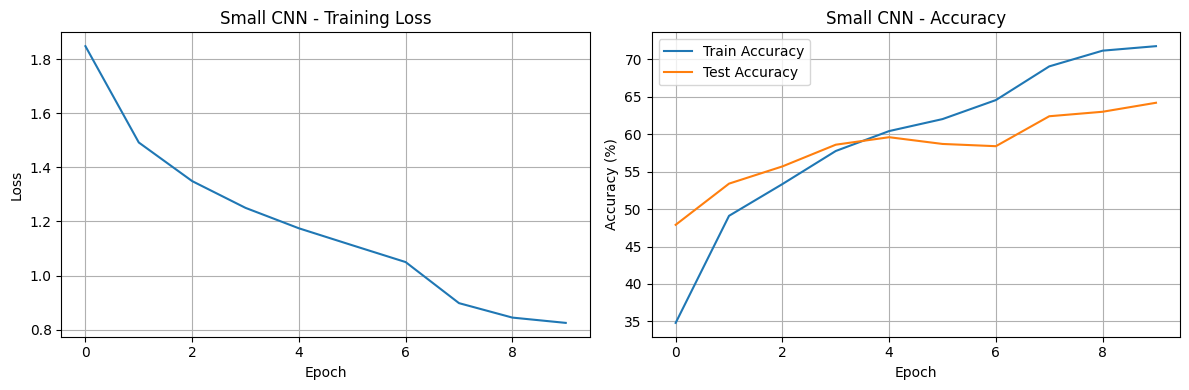

In [15]:
plot_training_curves(small_cnn_losses, small_cnn_train_acc, small_cnn_test_acc, "Small CNN")

In [16]:
# Generate confusion matrix for small CNN
def generate_confusion_matrix(model, test_loader, class_names, title):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return all_preds, all_labels

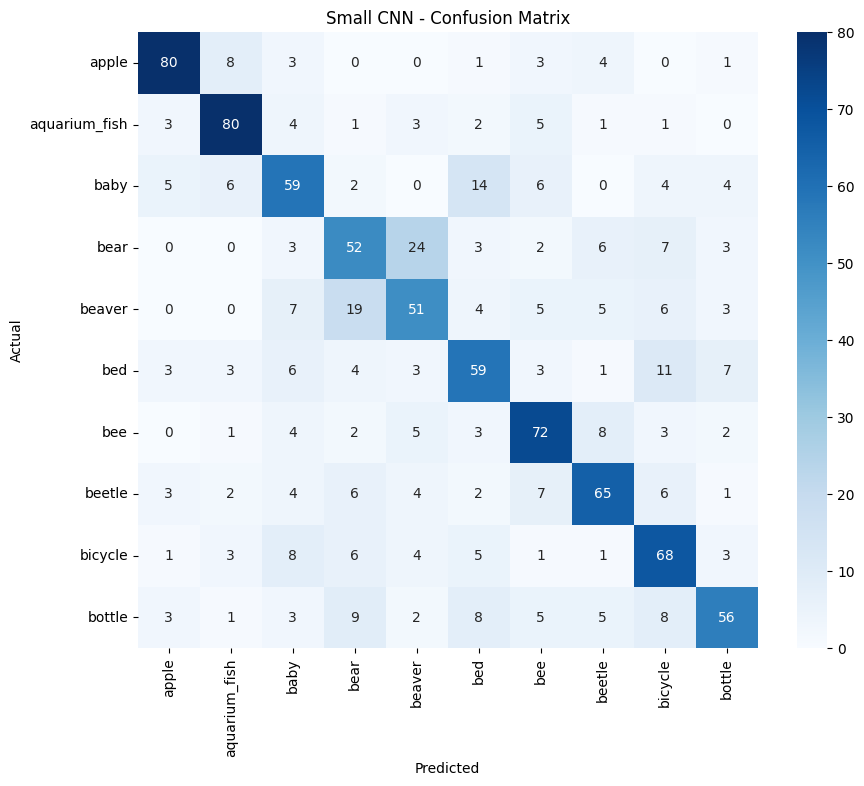

In [17]:
small_cnn_preds, small_cnn_labels = generate_confusion_matrix(
    small_cnn, test_loader_small, cifar100_classes[:10], "Small CNN"
)


In [18]:
# Step 4: Create and fine-tune VGG16 and EfficientNet
print("\nStep 4: Creating and fine-tuning VGG16 and EfficientNet")
print("="*60)

# VGG16
vgg16_model = vgg16(pretrained=True)
# Freeze all parameters
for param in vgg16_model.parameters():
    param.requires_grad = False

# Replace classifier for 10 classes
vgg16_model.classifier[6] = nn.Linear(4096, 10)

# Unfreeze only classifier[3] and classifier[6]
for idx in [3, 6]:
    for param in vgg16_model.classifier[idx].parameters():
        param.requires_grad = True

vgg16_model = vgg16_model.to(device)
print(f"VGG16 trainable parameters: {count_parameters(vgg16_model):,}")



Step 4: Creating and fine-tuning VGG16 and EfficientNet


d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16 trainable parameters: 16,822,282


In [19]:
# EfficientNet-B0
efficientnet_model = efficientnet_b0(pretrained=True)
# Freeze all parameters
for param in efficientnet_model.parameters():
    param.requires_grad = False

# Replace classifier for 10 classes
efficientnet_model.classifier[1] = nn.Linear(1280, 10)

# Unfreeze last layers (classifier)
for param in efficientnet_model.classifier.parameters():
    param.requires_grad = True

efficientnet_model = efficientnet_model.to(device)
print(f"EfficientNet-B0 trainable parameters: {count_parameters(efficientnet_model):,}")

EfficientNet-B0 trainable parameters: 12,810


d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training VGG16...
Epoch [1/10], Loss: 0.6933, Train Acc: 79.34%, Test Acc: 90.90%
Epoch [2/10], Loss: 0.3960, Train Acc: 87.64%, Test Acc: 90.90%
Epoch [3/10], Loss: 0.3564, Train Acc: 89.74%, Test Acc: 91.20%
Epoch [4/10], Loss: 0.2640, Train Acc: 91.24%, Test Acc: 90.20%
Epoch [5/10], Loss: 0.2723, Train Acc: 91.02%, Test Acc: 91.50%
Epoch [6/10], Loss: 0.2853, Train Acc: 91.90%, Test Acc: 91.70%
Epoch [7/10], Loss: 0.2252, Train Acc: 93.14%, Test Acc: 91.10%
Epoch [8/10], Loss: 0.0948, Train Acc: 96.72%, Test Acc: 93.60%
Epoch [9/10], Loss: 0.0787, Train Acc: 97.24%, Test Acc: 93.30%
Epoch [10/10], Loss: 0.0694, Train Acc: 97.58%, Test Acc: 93.10%


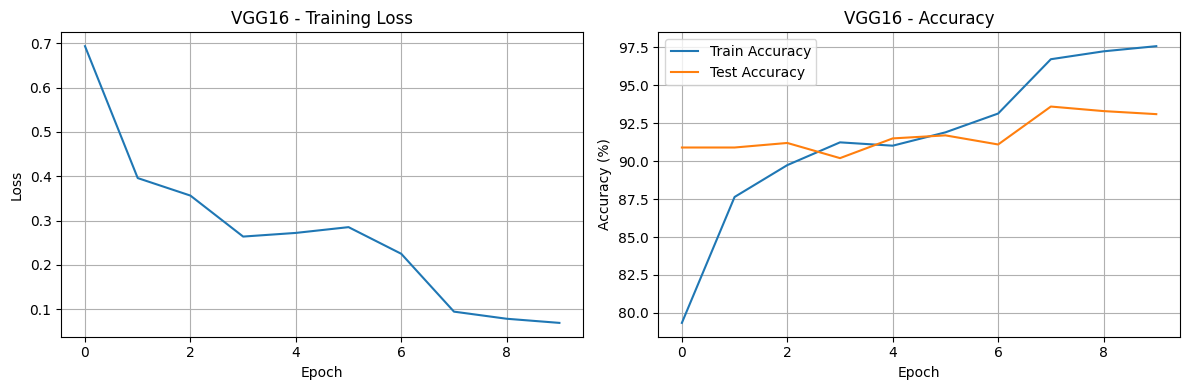

In [20]:
# Train VGG16
print("\nTraining VGG16...")
vgg16_losses, vgg16_train_acc, vgg16_test_acc = train_model(
    vgg16_model, train_loader_big, test_loader_big, epochs=10, lr=0.001
)

plot_training_curves(vgg16_losses, vgg16_train_acc, vgg16_test_acc, "VGG16")


Training EfficientNet-B0...
Epoch [1/10], Loss: 0.3935, Train Acc: 87.34%, Test Acc: 89.50%
Epoch [2/10], Loss: 0.3535, Train Acc: 88.90%, Test Acc: 90.00%
Epoch [3/10], Loss: 0.3559, Train Acc: 88.60%, Test Acc: 88.90%
Epoch [4/10], Loss: 0.3449, Train Acc: 88.50%, Test Acc: 88.90%
Epoch [5/10], Loss: 0.3187, Train Acc: 89.74%, Test Acc: 89.60%
Epoch [6/10], Loss: 0.3138, Train Acc: 89.86%, Test Acc: 89.50%
Epoch [7/10], Loss: 0.3176, Train Acc: 89.78%, Test Acc: 90.30%
Epoch [8/10], Loss: 0.2951, Train Acc: 90.32%, Test Acc: 89.40%
Epoch [9/10], Loss: 0.3010, Train Acc: 89.96%, Test Acc: 89.40%
Epoch [10/10], Loss: 0.2888, Train Acc: 90.16%, Test Acc: 89.80%


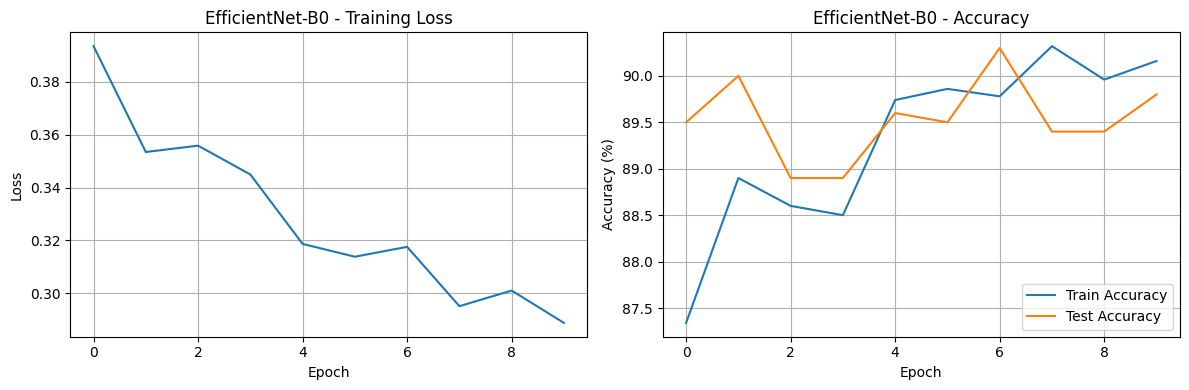

In [22]:
# Train EfficientNet
print("\nTraining EfficientNet-B0...")
efficientnet_losses, efficientnet_train_acc, efficientnet_test_acc = train_model(
    efficientnet_model, train_loader_big, test_loader_big, epochs=10, lr=0.001
)

plot_training_curves(efficientnet_losses, efficientnet_train_acc, efficientnet_test_acc, "EfficientNet-B0")


In [23]:
# Step 5: Knowledge Distillation (Individual Teachers)
print("\nStep 5: Knowledge Distillation - Individual Teachers")
print("="*60)

class KnowledgeDistillationLoss(nn.Module):
    def __init__(self, alpha=0.7, temperature=4):
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
    
    def forward(self, student_logits, teacher_logits, labels):
        # Hard loss (standard cross-entropy)
        hard_loss = F.cross_entropy(student_logits, labels)
        
        # Soft loss (knowledge distillation)
        soft_loss = F.kl_div(
            F.log_softmax(student_logits / self.temperature, dim=1),
            F.softmax(teacher_logits / self.temperature, dim=1),
            reduction='batchmean'
        ) * (self.temperature ** 2)
        
        return self.alpha * soft_loss + (1 - self.alpha) * hard_loss


Step 5: Knowledge Distillation - Individual Teachers


In [24]:
def train_with_distillation(student, teacher, train_loader, test_loader, epochs, lr=0.001):
    criterion = KnowledgeDistillationLoss()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    teacher.eval()  # Teacher is in evaluation mode
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        student.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Get teacher predictions
            with torch.no_grad():
                teacher_outputs = teacher(images)
            
            # Get student predictions
            student_outputs = student(images)
            
            # Compute distillation loss
            loss = criterion(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(student_outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        scheduler.step()
        
        # Testing phase
        student.eval()
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = student(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        train_acc = 100 * correct_train / total_train
        test_acc = 100 * correct_test / total_test
        
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    return train_losses, train_accuracies, test_accuracies

Knowledge Distillation: VGG16 -> Small CNN
Epoch [1/25], Loss: 14.6201, Train Acc: 33.94%, Test Acc: 44.10%
Epoch [2/25], Loss: 12.2207, Train Acc: 44.28%, Test Acc: 50.30%
Epoch [3/25], Loss: 11.0925, Train Acc: 48.64%, Test Acc: 52.00%
Epoch [4/25], Loss: 9.9756, Train Acc: 54.50%, Test Acc: 55.60%
Epoch [5/25], Loss: 9.1775, Train Acc: 56.84%, Test Acc: 58.60%
Epoch [6/25], Loss: 8.5420, Train Acc: 59.82%, Test Acc: 57.20%
Epoch [7/25], Loss: 8.0257, Train Acc: 62.46%, Test Acc: 58.70%
Epoch [8/25], Loss: 6.9960, Train Acc: 67.48%, Test Acc: 61.90%
Epoch [9/25], Loss: 6.7249, Train Acc: 68.40%, Test Acc: 63.40%
Epoch [10/25], Loss: 6.6228, Train Acc: 68.70%, Test Acc: 63.90%
Epoch [11/25], Loss: 6.5239, Train Acc: 69.86%, Test Acc: 64.00%
Epoch [12/25], Loss: 6.4475, Train Acc: 69.80%, Test Acc: 63.80%
Epoch [13/25], Loss: 6.3730, Train Acc: 70.04%, Test Acc: 64.20%
Epoch [14/25], Loss: 6.2798, Train Acc: 70.42%, Test Acc: 64.80%
Epoch [15/25], Loss: 6.1730, Train Acc: 71.08%, Test 

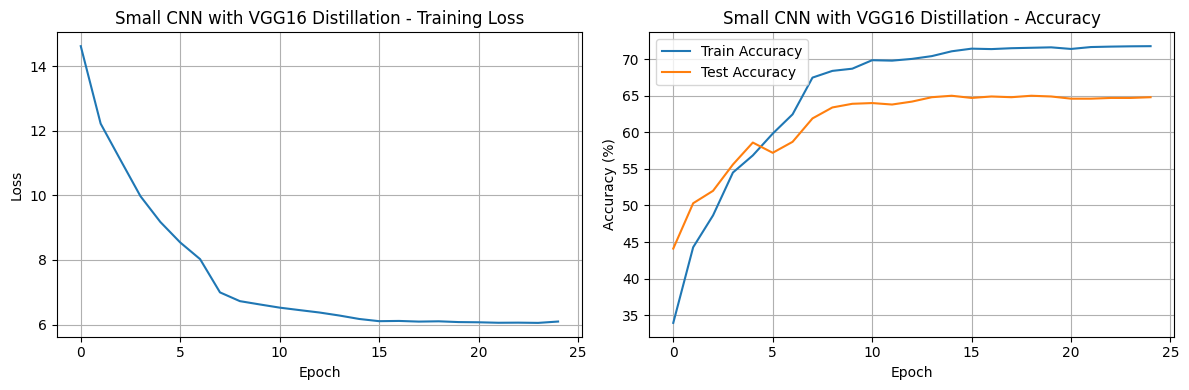

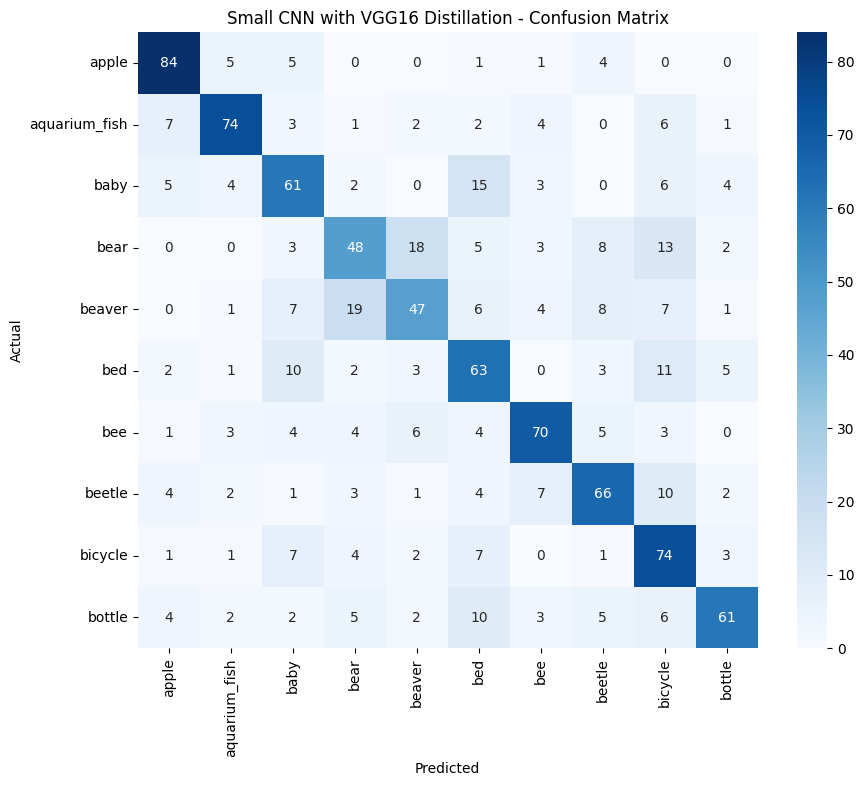

([0,
  8,
  9,
  3,
  2,
  9,
  2,
  0,
  3,
  0,
  9,
  8,
  2,
  4,
  8,
  8,
  3,
  4,
  7,
  6,
  6,
  2,
  0,
  2,
  4,
  2,
  1,
  1,
  6,
  8,
  5,
  7,
  3,
  8,
  7,
  7,
  0,
  6,
  4,
  2,
  8,
  3,
  8,
  2,
  5,
  9,
  7,
  5,
  5,
  6,
  0,
  8,
  4,
  0,
  9,
  5,
  8,
  4,
  2,
  8,
  5,
  2,
  5,
  2,
  9,
  6,
  1,
  4,
  0,
  1,
  5,
  4,
  3,
  0,
  5,
  8,
  4,
  1,
  1,
  6,
  1,
  0,
  1,
  4,
  3,
  9,
  7,
  7,
  0,
  8,
  6,
  6,
  7,
  6,
  9,
  1,
  2,
  8,
  2,
  7,
  6,
  3,
  2,
  8,
  2,
  1,
  5,
  1,
  0,
  3,
  5,
  6,
  9,
  5,
  3,
  7,
  7,
  1,
  8,
  4,
  6,
  1,
  9,
  9,
  0,
  5,
  2,
  2,
  3,
  5,
  8,
  7,
  6,
  9,
  5,
  2,
  3,
  0,
  0,
  4,
  5,
  5,
  7,
  0,
  2,
  5,
  6,
  0,
  4,
  5,
  2,
  8,
  5,
  8,
  1,
  9,
  4,
  8,
  4,
  2,
  7,
  9,
  8,
  7,
  9,
  4,
  2,
  9,
  3,
  5,
  3,
  9,
  2,
  2,
  3,
  8,
  7,
  5,
  7,
  2,
  7,
  0,
  3,
  8,
  1,
  8,
  1,
  2,
  6,
  1,
  5,
  3,
  2,
  5,
  7,
  6,
  7,
  3,
  3,
  0,


In [26]:
# Knowledge Distillation with VGG16
print("Knowledge Distillation: VGG16 -> Small CNN")
student_vgg16 = SmallCNN(num_classes=10).to(device)
vgg16_distill_losses, vgg16_distill_train_acc, vgg16_distill_test_acc = train_with_distillation(
    student_vgg16, vgg16_model, train_loader_small, test_loader_small, epochs=25
)

plot_training_curves(vgg16_distill_losses, vgg16_distill_train_acc, vgg16_distill_test_acc, 
                    "Small CNN with VGG16 Distillation")

generate_confusion_matrix(student_vgg16, test_loader_small, cifar100_classes[:10], 
                         "Small CNN with VGG16 Distillation")



Knowledge Distillation: EfficientNet -> Small CNN
Epoch [1/25], Loss: 4.7943, Train Acc: 35.34%, Test Acc: 46.20%
Epoch [2/25], Loss: 3.9668, Train Acc: 46.64%, Test Acc: 49.90%
Epoch [3/25], Loss: 3.4892, Train Acc: 53.14%, Test Acc: 55.60%
Epoch [4/25], Loss: 3.2168, Train Acc: 56.54%, Test Acc: 58.20%
Epoch [5/25], Loss: 3.0072, Train Acc: 59.60%, Test Acc: 57.10%
Epoch [6/25], Loss: 2.8512, Train Acc: 61.34%, Test Acc: 58.70%
Epoch [7/25], Loss: 2.6916, Train Acc: 63.26%, Test Acc: 60.00%
Epoch [8/25], Loss: 2.4329, Train Acc: 67.56%, Test Acc: 63.10%
Epoch [9/25], Loss: 2.3631, Train Acc: 68.74%, Test Acc: 63.70%
Epoch [10/25], Loss: 2.3376, Train Acc: 69.04%, Test Acc: 63.10%
Epoch [11/25], Loss: 2.3077, Train Acc: 69.44%, Test Acc: 63.20%
Epoch [12/25], Loss: 2.2905, Train Acc: 69.32%, Test Acc: 64.30%
Epoch [13/25], Loss: 2.2659, Train Acc: 70.00%, Test Acc: 63.90%
Epoch [14/25], Loss: 2.2519, Train Acc: 70.10%, Test Acc: 64.60%
Epoch [15/25], Loss: 2.2102, Train Acc: 70.84%, 

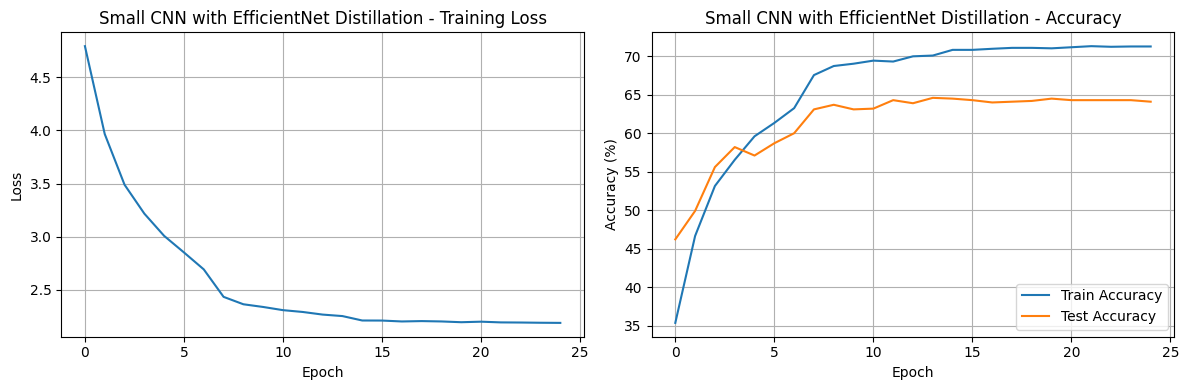

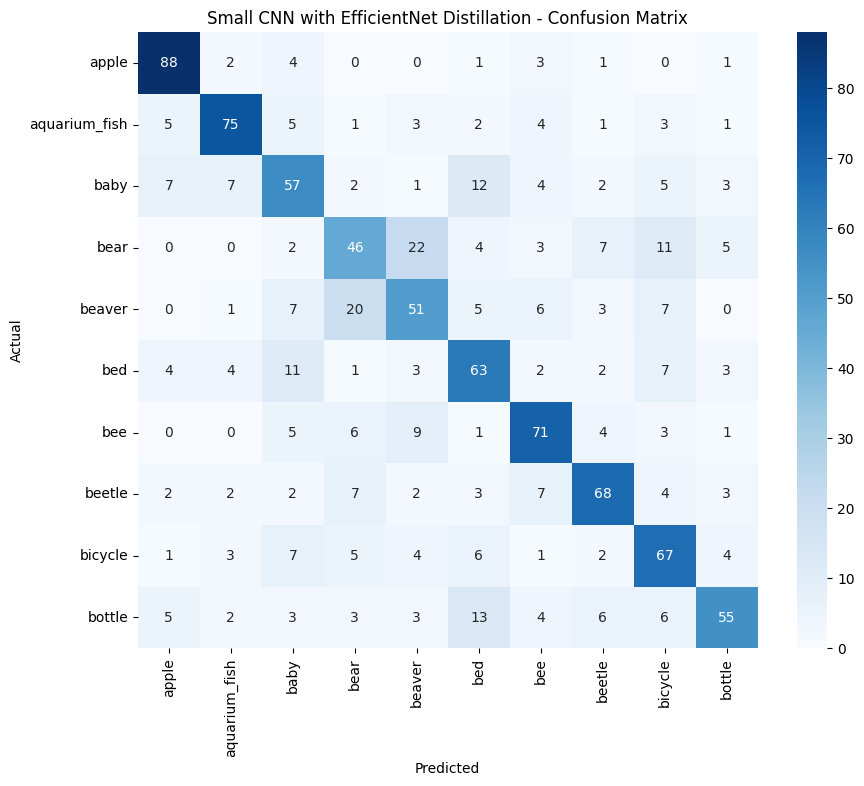

([0,
  8,
  9,
  5,
  9,
  9,
  2,
  1,
  6,
  0,
  5,
  8,
  7,
  4,
  8,
  8,
  9,
  4,
  7,
  6,
  6,
  2,
  0,
  2,
  4,
  2,
  1,
  6,
  6,
  8,
  5,
  7,
  2,
  8,
  7,
  7,
  0,
  6,
  4,
  2,
  9,
  3,
  8,
  2,
  5,
  9,
  7,
  5,
  5,
  6,
  0,
  8,
  4,
  0,
  9,
  5,
  8,
  3,
  2,
  8,
  5,
  2,
  5,
  2,
  9,
  6,
  1,
  4,
  0,
  1,
  5,
  4,
  3,
  0,
  5,
  8,
  4,
  1,
  2,
  6,
  1,
  0,
  1,
  4,
  3,
  9,
  7,
  7,
  0,
  1,
  6,
  6,
  7,
  6,
  9,
  1,
  2,
  8,
  2,
  7,
  6,
  8,
  2,
  8,
  2,
  0,
  5,
  4,
  0,
  3,
  5,
  6,
  9,
  7,
  3,
  7,
  7,
  1,
  3,
  4,
  6,
  1,
  9,
  9,
  0,
  5,
  2,
  2,
  3,
  5,
  8,
  7,
  6,
  9,
  5,
  2,
  3,
  0,
  0,
  4,
  5,
  5,
  7,
  0,
  5,
  5,
  6,
  0,
  4,
  5,
  2,
  8,
  5,
  8,
  1,
  9,
  3,
  8,
  3,
  2,
  7,
  5,
  9,
  3,
  9,
  4,
  2,
  9,
  3,
  5,
  3,
  7,
  3,
  2,
  3,
  8,
  7,
  6,
  7,
  2,
  2,
  0,
  3,
  8,
  1,
  8,
  0,
  2,
  6,
  1,
  5,
  3,
  2,
  9,
  7,
  6,
  7,
  4,
  3,
  0,


In [27]:
# Knowledge Distillation with EfficientNet
print("\nKnowledge Distillation: EfficientNet -> Small CNN")
student_efficientnet = SmallCNN(num_classes=10).to(device)
efficientnet_distill_losses, efficientnet_distill_train_acc, efficientnet_distill_test_acc = train_with_distillation(
    student_efficientnet, efficientnet_model, train_loader_small, test_loader_small, epochs=25
)

plot_training_curves(efficientnet_distill_losses, efficientnet_distill_train_acc, efficientnet_distill_test_acc, 
                    "Small CNN with EfficientNet Distillation")

generate_confusion_matrix(student_efficientnet, test_loader_small, cifar100_classes[:10], 
                         "Small CNN with EfficientNet Distillation")

In [31]:
class CombinedKnowledgeDistillationLoss(nn.Module):
    def __init__(self, alpha=0.7, temperature=4):
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
    
    def forward(self, student_logits, teacher1_logits, teacher2_logits, labels):
        # Hard loss (standard cross-entropy)
        hard_loss = F.cross_entropy(student_logits, labels)
        
        # Combine teacher predictions (ensemble)
        combined_teacher_logits = (teacher1_logits + teacher2_logits) / 2
        
        # Soft loss (knowledge distillation with combined teachers)
        soft_loss = F.kl_div(
            F.log_softmax(student_logits / self.temperature, dim=1),
            F.softmax(combined_teacher_logits / self.temperature, dim=1),
            reduction='batchmean'
        ) * (self.temperature ** 2)
        
        return self.alpha * soft_loss + (1 - self.alpha) * hard_loss

In [32]:
def train_with_combined_distillation(student, teacher1, teacher2, train_loader, test_loader, epochs, lr=0.001):
    criterion = CombinedKnowledgeDistillationLoss()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    teacher1.eval()
    teacher2.eval()
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        student.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Get teacher predictions
            with torch.no_grad():
                teacher1_outputs = teacher1(images)
                teacher2_outputs = teacher2(images)
            
            # Get student predictions
            student_outputs = student(images)
            
            # Compute combined distillation loss
            loss = criterion(student_outputs, teacher1_outputs, teacher2_outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(student_outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        scheduler.step()
        
        # Testing phase
        student.eval()
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = student(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        train_acc = 100 * correct_train / total_train
        test_acc = 100 * correct_test / total_test
        
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    return train_losses, train_accuracies, test_accuracies

Combined Knowledge Distillation: VGG16 + EfficientNet -> Small CNN
Epoch [1/15], Loss: 11.2127, Train Acc: 32.76%, Test Acc: 41.40%
Epoch [2/15], Loss: 9.2186, Train Acc: 44.08%, Test Acc: 47.70%
Epoch [3/15], Loss: 8.3784, Train Acc: 49.04%, Test Acc: 50.60%
Epoch [4/15], Loss: 7.7698, Train Acc: 51.64%, Test Acc: 54.20%
Epoch [5/15], Loss: 7.2522, Train Acc: 54.64%, Test Acc: 54.20%
Epoch [6/15], Loss: 6.6175, Train Acc: 57.56%, Test Acc: 57.10%
Epoch [7/15], Loss: 6.0900, Train Acc: 61.42%, Test Acc: 58.20%
Epoch [8/15], Loss: 5.2910, Train Acc: 65.94%, Test Acc: 61.10%
Epoch [9/15], Loss: 5.0389, Train Acc: 67.42%, Test Acc: 61.00%
Epoch [10/15], Loss: 4.9468, Train Acc: 68.28%, Test Acc: 61.80%
Epoch [11/15], Loss: 4.8656, Train Acc: 68.56%, Test Acc: 62.90%
Epoch [12/15], Loss: 4.8024, Train Acc: 68.76%, Test Acc: 62.90%
Epoch [13/15], Loss: 4.7342, Train Acc: 68.92%, Test Acc: 63.10%
Epoch [14/15], Loss: 4.6582, Train Acc: 69.64%, Test Acc: 63.60%
Epoch [15/15], Loss: 4.5553, Tr

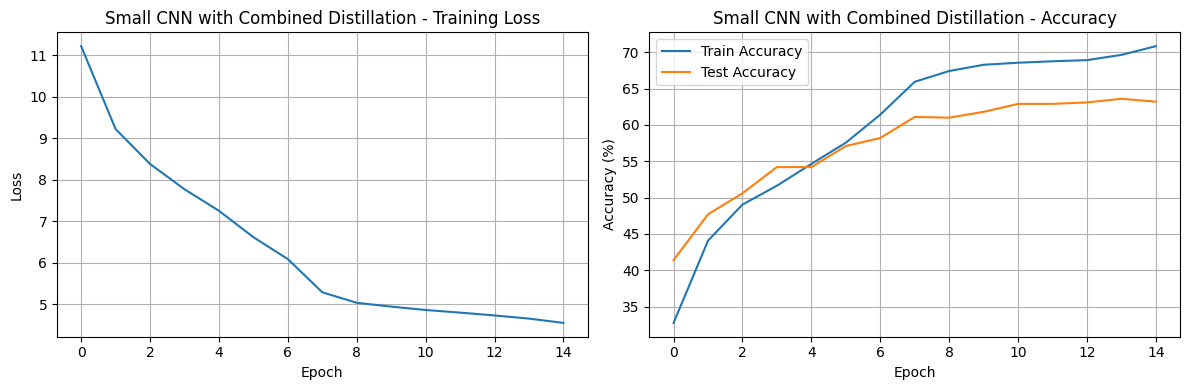

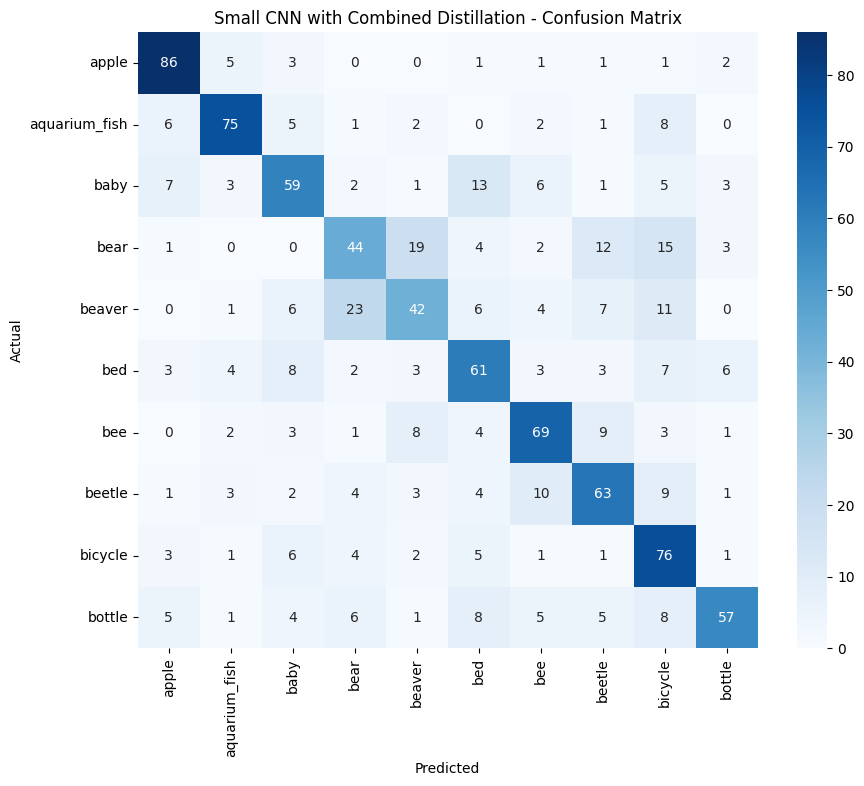

([0,
  8,
  2,
  4,
  6,
  9,
  2,
  1,
  6,
  0,
  5,
  8,
  0,
  4,
  8,
  8,
  9,
  4,
  7,
  6,
  6,
  2,
  0,
  2,
  4,
  2,
  1,
  6,
  6,
  8,
  5,
  7,
  3,
  8,
  6,
  7,
  0,
  6,
  0,
  2,
  8,
  3,
  8,
  2,
  5,
  9,
  7,
  5,
  5,
  6,
  0,
  8,
  3,
  0,
  9,
  5,
  8,
  1,
  2,
  8,
  8,
  2,
  3,
  2,
  6,
  6,
  1,
  4,
  0,
  1,
  5,
  4,
  3,
  0,
  5,
  8,
  4,
  1,
  1,
  6,
  1,
  0,
  1,
  8,
  4,
  9,
  7,
  7,
  0,
  8,
  6,
  6,
  7,
  6,
  9,
  1,
  2,
  8,
  2,
  7,
  6,
  3,
  2,
  5,
  2,
  0,
  8,
  1,
  0,
  3,
  5,
  6,
  8,
  7,
  3,
  7,
  7,
  1,
  8,
  4,
  6,
  1,
  9,
  9,
  0,
  5,
  2,
  2,
  3,
  5,
  8,
  8,
  6,
  9,
  5,
  3,
  3,
  0,
  0,
  4,
  5,
  5,
  7,
  1,
  5,
  7,
  6,
  0,
  4,
  5,
  2,
  8,
  5,
  8,
  1,
  9,
  3,
  8,
  3,
  8,
  7,
  9,
  8,
  6,
  9,
  4,
  2,
  9,
  3,
  5,
  3,
  8,
  3,
  2,
  3,
  8,
  7,
  6,
  7,
  2,
  7,
  0,
  3,
  8,
  1,
  8,
  1,
  2,
  6,
  1,
  5,
  4,
  2,
  5,
  7,
  6,
  7,
  4,
  8,
  0,


In [33]:
# Combined Knowledge Distillation
print("Combined Knowledge Distillation: VGG16 + EfficientNet -> Small CNN")
student_combined = SmallCNN(num_classes=10).to(device)
combined_distill_losses, combined_distill_train_acc, combined_distill_test_acc = train_with_combined_distillation(
    student_combined, vgg16_model, efficientnet_model, train_loader_small, test_loader_small, epochs=15
)

plot_training_curves(combined_distill_losses, combined_distill_train_acc, combined_distill_test_acc, 
                    "Small CNN with Combined Distillation")

generate_confusion_matrix(student_combined, test_loader_small, cifar100_classes[:10], 
                         "Small CNN with Combined Distillation")

In [36]:
# Final Performance Comparison
print("\n" + "="*80)
print("FINAL PERFORMANCE COMPARISON REPORT")
print("="*80)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


FINAL PERFORMANCE COMPARISON REPORT


In [37]:

# Calculate final accuracies
small_cnn_acc = evaluate_model(small_cnn, test_loader_small)
vgg16_acc = evaluate_model(vgg16_model, test_loader_big)
efficientnet_acc = evaluate_model(efficientnet_model, test_loader_big)
student_vgg16_acc = evaluate_model(student_vgg16, test_loader_small)
student_efficientnet_acc = evaluate_model(student_efficientnet, test_loader_small)
student_combined_acc = evaluate_model(student_combined, test_loader_small)

In [39]:
# Performance summary
results = {
    'Model': ['Small CNN (Baseline)', 'VGG16 (Fine-tuned)', 'EfficientNet-B0 (Fine-tuned)',
              'Small CNN + VGG16 KD', 'Small CNN + EfficientNet KD', 'Small CNN + Combined KD'],
    'Test Accuracy (%)': [small_cnn_acc, vgg16_acc, efficientnet_acc, 
                         student_vgg16_acc, student_efficientnet_acc, student_combined_acc],
    'Parameters': [count_parameters(small_cnn), count_parameters(vgg16_model), 
                   count_parameters(efficientnet_model), count_parameters(student_vgg16),
                   count_parameters(student_efficientnet), count_parameters(student_combined)]
}

In [40]:
print("\nPerformance Summary:")
print("-" * 60)
for i in range(len(results['Model'])):
    print(f"{results['Model'][i]:<25} | {results['Test Accuracy (%)'][i]:<12.2f} | {results['Parameters'][i]:<10,}")


Performance Summary:
------------------------------------------------------------
Small CNN (Baseline)      | 64.20        | 156,074   
VGG16 (Fine-tuned)        | 93.10        | 16,822,282
EfficientNet-B0 (Fine-tuned) | 89.80        | 12,810    
Small CNN + VGG16 KD      | 64.80        | 156,074   
Small CNN + EfficientNet KD | 64.10        | 156,074   
Small CNN + Combined KD   | 63.20        | 156,074   


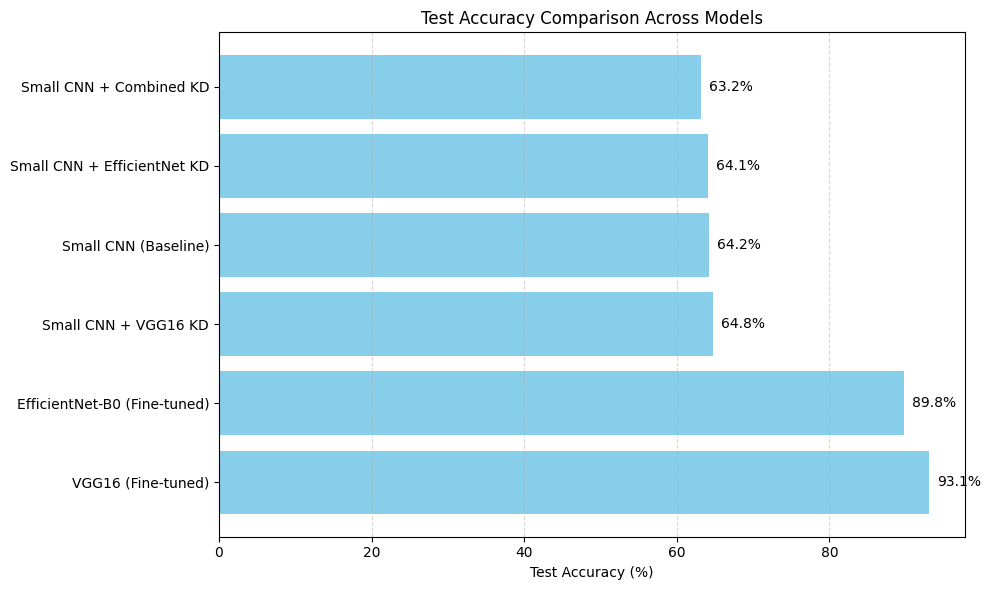

In [43]:
# Extract data
models = results['Model']
accuracies = results['Test Accuracy (%)']

# Sort by accuracy (optional for better readability)
sorted_data = sorted(zip(accuracies, models), reverse=True)
accuracies_sorted, models_sorted = zip(*sorted_data)

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(models_sorted, accuracies_sorted, color='skyblue')
plt.xlabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison Across Models')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Annotate each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f'{width:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()